<a href="https://colab.research.google.com/github/Keval1998/ir_paraphrase/blob/master/ParaPhrase_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount google drive

use given code if direct mount drive if permission is not given for colaboratory access

My BASR_DIR - https://drive.google.com/open?id=1NoWhs64hmQym9UERMBkuGyYvSL3xahBW 
add it to your drive to get the data and results
use path of this shared folder as BASE_DIR

this shared folder contains each used and output files with the same name given in this notebook, for view purpose link is also provided with each file name in code

In [0]:
from google.colab import drive
drive.mount('/content/drive')

To see direct results run last 3 cells
Results are predicted using 23 epochs

All packages required

In [1]:
%tensorflow_version 1.x
import os
import re
import csv
import codecs
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

TensorFlow 1.x selected.


Using TensorFlow backend.


All constants defined that code will use later

BASE_DIR folder is shared and link is given in first cell before moun drive

if want to see direct files then you can use link of files directly provided

EMBEDDING_FILE : link to GoogleNeews preembedded vectors  https://drive.google.com/open?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
 use the link to add shortcut in your drive

 TRAIN_DATA_FILE : csv file for testing https://drive.google.com/open?id=1C8lQsimHfvgT3RcJbpcbYqLVwatpMfnI

 TEST_DATA_FILE : csv file for testing https://drive.google.com/open?id=1SyUgSjOBllW6Vesql1F-erS6wSB-mdOb

In [4]:
BASE_DIR = '/content/drive/My Drive/irlabs/impl/'
EMBEDDING_FILE = BASE_DIR + 'GoogleNews-vectors-negative300 (1).bin.gz'
TRAIN_DATA_FILE = BASE_DIR + '2.txt'#(sample file) #use train.csv instead of 2.txt to observe full run on original data
TEST_DATA_FILE = BASE_DIR + '1.txt'#(sample file) #test.csv instead of 1.txt to observe full run on original data
MAX_SEQUENCE_LENGTH = 30
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1

num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

act = 'relu'
re_weight = True
STAMP = 'lstm_%d_%d_%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm,rate_drop_dense)

word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE,binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


function for data cleaning

In [0]:
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    text = text.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    

    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    

    return(text)

preprocessing

In [0]:
texts_1 = [] 
texts_2 = []
labels = []
with codecs.open(TRAIN_DATA_FILE, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        texts_1.append(text_to_wordlist(values[3]))
        texts_2.append(text_to_wordlist(values[4]))
        labels.append(int(values[5]))

test_texts_1 = []
test_texts_2 = []
test_ids = []
with codecs.open(TEST_DATA_FILE, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    header = next(reader)
    for values in reader:
        test_texts_1.append(text_to_wordlist(values[1]))
        test_texts_2.append(text_to_wordlist(values[2]))
        test_ids.append(values[0])

In [6]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_1 + texts_2 + test_texts_1 + test_texts_2)

sequences_1 = tokenizer.texts_to_sequences(texts_1)
sequences_2 = tokenizer.texts_to_sequences(texts_2)
test_sequences_1 = tokenizer.texts_to_sequences(test_texts_1)
test_sequences_2 = tokenizer.texts_to_sequences(test_texts_2)

word_index = tokenizer.word_index
data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(labels)
test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
test_data_2 = pad_sequences(test_sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
test_ids = np.array(test_ids)

nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
print('Number of words not found in embedding: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

perm = np.random.permutation(len(data_1))
idx_train = perm[:int(len(data_1)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(data_1)*(1-VALIDATION_SPLIT)):]

data_1_train = np.vstack((data_1[idx_train], data_2[idx_train]))
data_2_train = np.vstack((data_2[idx_train], data_1[idx_train]))
labels_train = np.concatenate((labels[idx_train], labels[idx_train]))

data_1_val = np.vstack((data_1[idx_val], data_2[idx_val]))
data_2_val = np.vstack((data_2[idx_val], data_1[idx_val]))
labels_val = np.concatenate((labels[idx_val], labels[idx_val]))

weight_val = np.ones(len(labels_val))
if re_weight:
    weight_val *= 0.472001959
    weight_val[labels_val==0] = 1.309028344

embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)

lstm_layer = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

merged = concatenate([x1, y1])
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

preds = Dense(1, activation='sigmoid')(merged)

if re_weight:
    class_weight = {0: 1.309028344, 1: 0.472001959}
else:
    class_weight = None

model = Model(inputs=[sequence_1_input, sequence_2_input],outputs=preds)
model.compile(loss='binary_crossentropy',
        optimizer='nadam',
        metrics=['acc'])

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

Number of words not found in embedding: 236
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
hist = model.fit([data_1_train, data_2_train], labels_train, \
        validation_data=([data_1_val, data_2_val], labels_val, weight_val), \
        epochs=50, batch_size=2048, shuffle=True, \
        class_weight=class_weight, callbacks=[early_stopping, model_checkpoint])

model.load_weights(bst_model_path)
bst_val_score = min(hist.history['val_loss'])

Train on 892 samples, validate on 100 samples
Epoch 1/50
892/892 [==============================] - 4s 5ms/step - loss: 0.4945 - acc: 0.7601 - val_loss: 0.6488 - val_acc: 0.6400
Epoch 2/50
892/892 [==============================] - 4s 5ms/step - loss: 0.4310 - acc: 0.7982 - val_loss: 0.6494 - val_acc: 0.6000
Epoch 3/50
892/892 [==============================] - 4s 5ms/step - loss: 0.4140 - acc: 0.7993 - val_loss: 0.6204 - val_acc: 0.6400
Epoch 4/50
892/892 [==============================] - 4s 5ms/step - loss: 0.4138 - acc: 0.8061 - val_loss: 0.6645 - val_acc: 0.5900
Epoch 5/50
892/892 [==============================] - 4s 5ms/step - loss: 0.4218 - acc: 0.8150 - val_loss: 0.5929 - val_acc: 0.6200
Epoch 6/50
892/892 [==============================] - 6s 7ms/step - loss: 0.3681 - acc: 0.8408 - val_loss: 0.6045 - val_acc: 0.6200
Epoch 7/50
892/892 [==============================] - 6s 7ms/step - loss: 0.2974 - acc: 0.8778 - val_loss: 0.5935 - val_acc: 0.6200
Epoch 8/50
892/892 [==========

In [9]:
print('Test File')

preds = model.predict([test_data_1, test_data_2], batch_size=8192, verbose=1)
preds += model.predict([test_data_2, test_data_1], batch_size=8192, verbose=1)
preds /= 2

submission = pd.DataFrame({'test_id':test_ids, 'is_duplicate':preds.ravel()})
submission.to_csv(BASE_DIR+"RESULT.csv", index=False) #RESULT.csv(sample file) is similarity values of test data
                                                      #instead of BASE_DIR here use your folder;s path or just RESULT.csv
                                                      #with test pair id from test.csv(TEST_DATA_FILE) 
                                                      #test.csv - https://drive.google.com/open?id=1SyUgSjOBllW6Vesql1F-erS6wSB-mdOb
                                                      #RESULT.csv - https://drive.google.com/open?id=1XBs91f0WCOGqaAMjPfqtFYuqqV9oprTc

Test File
164/164 [==============================] - 0s 2ms/step


Original result is in ans2.csv in shared BASE_DIR

direct file is available here: https://drive.google.com/open?id=1-3RHeIeJus8M1cOH-B4ZOw8SCvJpNmtN

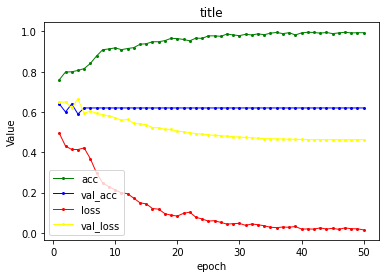

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel('epoch')
plt.ylabel('Value')
plt.title('title')

plt.plot(range(1,51),hist.history['acc'],marker='o',color='green',markerfacecolor='green',markersize=2,linewidth=1,label='acc')
plt.plot(range(1,51),hist.history['val_acc'],marker='o',color='blue',markerfacecolor='blue',markersize=2,linewidth=1,label='val_acc')
plt.plot(range(1,51),hist.history['loss'],marker='o',color='red',markerfacecolor='red',markersize=2,linewidth=1,label='loss')
plt.plot(range(1,51),hist.history['val_loss'],marker='o',color='yellow',markerfacecolor='yellow',markersize=2,linewidth=1,label='val_loss')

plt.legend()
plt.show()

**Saved Values after 23 epochs**


instead of BASE_DIR+links will be needed to replace with links of files given in shared links ![alt text](https://)

In [0]:
import pickle
BASE_DIR = '/content/drive/My Drive/irlabs/impl/'

with open(BASE_DIR+'preds.pickle', 'rb') as f: #https://drive.google.com/open?id=1-6pQ6hiVA6QDALeyhc4hkpTncUmqHXni
  preds = pickle.load(f)

with open(BASE_DIR+'test_ids.pickle', 'rb') as f: #https://drive.google.com/open?id=1-5aOsp4QdbpWxRgSayqdbuTu_sV8I-PF
  test_ids = pickle.load(f)

with open(BASE_DIR+'acc.pickle', 'rb') as f:  #https://drive.google.com/open?id=1lABTT-Ssyf3jwZvBaTSuHEM8yaLhYuMY
  acc = pickle.load(f)

with open(BASE_DIR+'val_acc.pickle', 'rb') as f: #https://drive.google.com/open?id=1-0bqZ8EuCPinjKwD99POPje1sxqJG_pe
  val_acc = pickle.load(f)

with open(BASE_DIR+'loss.pickle', 'rb') as f: #https://drive.google.com/open?id=13zxmc2FpC7SiVBQc7G2sjatgU5FYe2e6
  loss = pickle.load(f)

with open(BASE_DIR+'val_loss.pickle', 'rb') as f: #https://drive.google.com/open?id=1--vkjNlRs8_YM_gG7GJkQkdpY1K02r9n
  val_loss = pickle.load(f)

import pandas as pd
submission = pd.DataFrame({'test_id':test_ids, 'is_duplicate':preds.ravel()})

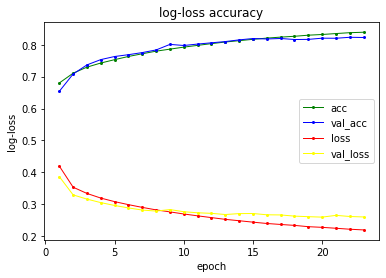

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel('epoch')
plt.ylabel('log-loss')
plt.title('log-loss accuracy')
max_val = len(acc)+1

plt.plot(range(1,max_val),acc,marker='o',color='green',markerfacecolor='green',markersize=2,linewidth=1,label='acc')
plt.plot(range(1,max_val),val_acc,marker='o',color='blue',markerfacecolor='blue',markersize=2,linewidth=1,label='val_acc')
plt.plot(range(1,max_val),loss,marker='o',color='red',markerfacecolor='red',markersize=2,linewidth=1,label='loss')
plt.plot(range(1,max_val),val_loss,marker='o',color='yellow',markerfacecolor='yellow',markersize=2,linewidth=1,label='val_loss')

plt.legend()
plt.show()

**13 epoch evaluation**

In [0]:
with open(BASE_DIR+'acc1.pickle', 'rb') as f:  #https://drive.google.com/open?id=1fAbf1mbnJLd8ivD7TnfFfKjAashLtLWd
  acc1 = pickle.load(f)

with open(BASE_DIR+'val_acc1.pickle', 'rb') as f: #https://drive.google.com/open?id=1-50gUK6ExBr0Qj5G3iyjDf10OrJNzDCz
  val_acc1 = pickle.load(f)

with open(BASE_DIR+'loss1.pickle', 'rb') as f: #https://drive.google.com/open?id=1-84BRU8gFqftB5J_BVh2Z-9lcrxF8w9J
  loss1 = pickle.load(f)

with open(BASE_DIR+'val_loss1.pickle', 'rb') as f: #https://drive.google.com/open?id=1-3BobXMI_1bwiZ2MqXziJGFPutQW1SY6
  val_loss1 = pickle.load(f)


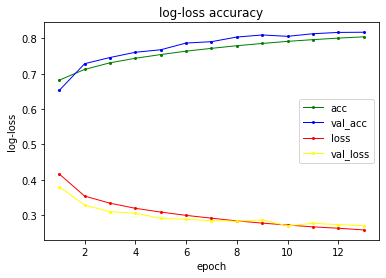

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel('epoch')
plt.ylabel('log-loss')
plt.title('log-loss accuracy')
max_val1 = len(acc1)+1

plt.plot(range(1,max_val1),acc1,marker='o',color='green',markerfacecolor='green',markersize=2,linewidth=1,label='acc')
plt.plot(range(1,max_val1),val_acc1,marker='o',color='blue',markerfacecolor='blue',markersize=2,linewidth=1,label='val_acc')
plt.plot(range(1,max_val1),loss1,marker='o',color='red',markerfacecolor='red',markersize=2,linewidth=1,label='loss')
plt.plot(range(1,max_val1),val_loss1,marker='o',color='yellow',markerfacecolor='yellow',markersize=2,linewidth=1,label='val_loss')

plt.legend()
plt.show()